## Import Libraries

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

## Load the Datasets

In [2]:
test = pd.read_csv("../data/Test_0qrQsBZ.csv")
train = pd.read_csv("../data/Train_SU63ISt.csv")

In [3]:
test_original=test.copy()
train_original=train.copy()

## Understand Data Structure & Content

In [4]:
print("=====Train Data Columns=====")
print(train.columns)
print("\n=====Test Data Columns=====")
print(test.columns)

=====Train Data Columns=====
Index(['ID', 'Datetime', 'Count'], dtype='object')

=====Test Data Columns=====
Index(['ID', 'Datetime'], dtype='object')


In [5]:
print("=====Train data types=====")
print(train.dtypes)
print("\n=====Test data types=====")
print(test.dtypes)

=====Train data types=====
ID           int64
Datetime    object
Count        int64
dtype: object

=====Test data types=====
ID           int64
Datetime    object
dtype: object


In [6]:
print("=====Train Data=====")
print(train.head())
print("\n=====Test Data=====")
print(test.head())

=====Train Data=====
   ID          Datetime  Count
0   0  25-08-2012 00:00      8
1   1  25-08-2012 01:00      2
2   2  25-08-2012 02:00      6
3   3  25-08-2012 03:00      2
4   4  25-08-2012 04:00      2

=====Test Data=====
      ID          Datetime
0  18288  26-09-2014 00:00
1  18289  26-09-2014 01:00
2  18290  26-09-2014 02:00
3  18291  26-09-2014 03:00
4  18292  26-09-2014 04:00


In [18]:
print("=====Train Data size=====")
print(train.shape)
print("\n=====Test Data size=====")
print(test.shape)

=====Train Data size=====
(18288, 3)

=====Test Data size=====
(5112, 2)


## Feature Extraction

In [7]:
# Convert Datetime object to python Datetime format
train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')

In [9]:
# Extract year, month, day, hour from datetime object
for i in (train, test):
    i['Year'] = i['Datetime'].dt.year
    i['Month'] = i['Datetime'].dt.month
    i['Day'] = i['Datetime'].dt.day
    i['Hour'] = i['Datetime'].dt.hour
    i['Day of Week'] = i['Datetime'].dt.dayofweek

In [10]:
# Weekend checker

def check_weekend(dow):
    
    if dow == 5 or dow == 6:
        return 1
    
    else:
        return 0
    

# Apply on train set and create a new column isWeekend (1 for yes and 0 for no)

train['isWeekend'] = train['Day of Week'].apply(check_weekend)

## Plotting the time series

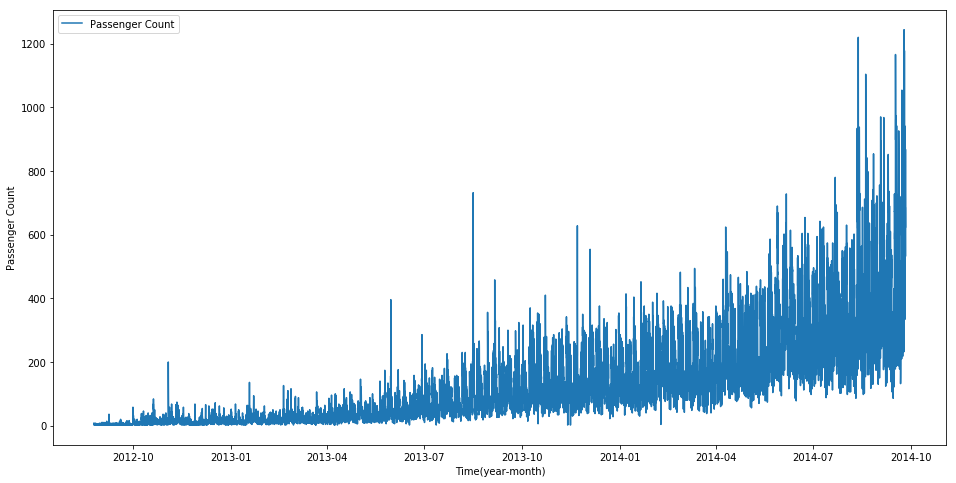

In [73]:
plt.figure(figsize=(16, 8))

plt.xlabel('Time(year-month)')
plt.ylabel('Passenger Count')
plt.plot(train.Datetime, train.Count, label='Passenger Count')
plt.legend(loc='best')
plt.show()

## Exploratory Anlaysis

Various ways to analyze this data are:

1. Plot the data by year and analyze the increase per year
2. Plot the data by day of week and analyze the distribution of traffic across different days
3. Analyze the rate of increase by each month
4. Analyze the hourly traffic
5. Analyze the trend in difference in passenger count with respect to weekend/non-weekend days
6. Beware of the outliers caused by special days (holidays, weekends, some other day of public interest, etc)

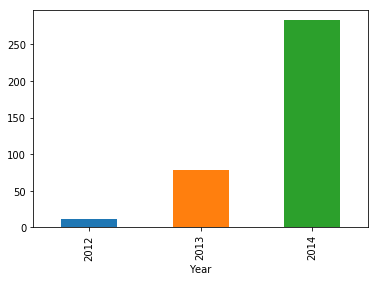

In [74]:
train.groupby('Year')['Count'].mean().plot.bar()

The average passenger count increases exponentially every year

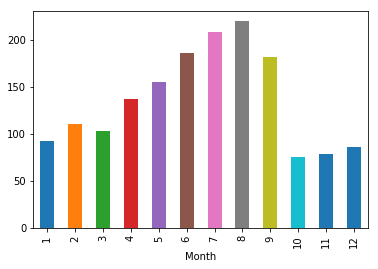

In [78]:
train.groupby(['Month'])['Count'].mean().plot.bar()

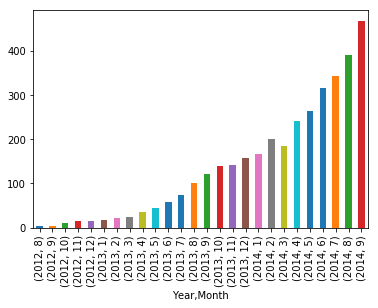

In [79]:
train.groupby(['Year', 'Month'])['Count'].mean().plot.bar()

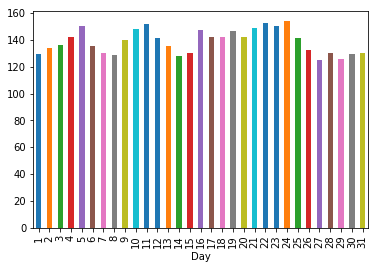

In [81]:
train.groupby(['Day'])['Count'].mean().plot.bar()

This plot doesn't give much insight

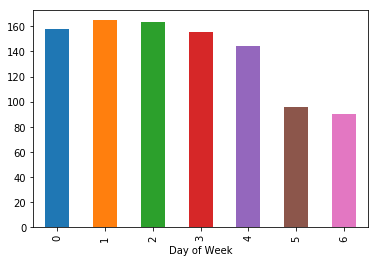

In [82]:
train.groupby(['Day of Week'])['Count'].mean().plot.bar()

Clearly, the traffic is more on weekdays and less on weekends

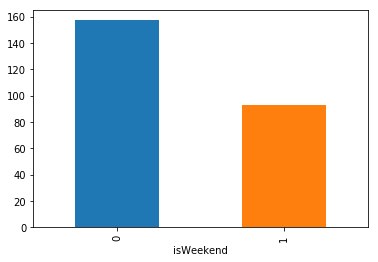

In [84]:
train.groupby('isWeekend')['Count'].mean().plot.bar()

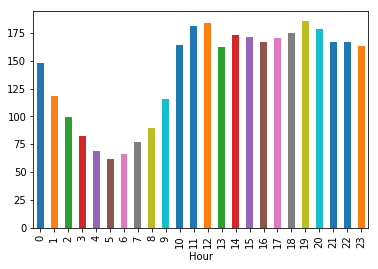

In [85]:
train.groupby('Hour')['Count'].mean().plot.bar()

As expected, 9am-12pm are peak hours in morning time; 5pm-7pm are peak hours in evening.
The traffic starts decreasing from 7pm till 5am next day continuously and again starts increasing after that.

Let's drop the ID column as it is of no use

In [86]:
train=train.drop('ID', 1)

As we have seen that there is a lot of noise in the hourly time series, we will aggregate the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

In [88]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp

# Hourly time series
hourly = train.resample('H').mean()

# Converting to daily mean
daily = train.resample('D').mean()

# Converting to weekly mean
weekly = train.resample('W').mean()

# Converting to monthly mean
monthly = train.resample('M').mean()

Let’s look at the hourly, daily, weekly and monthly time series.

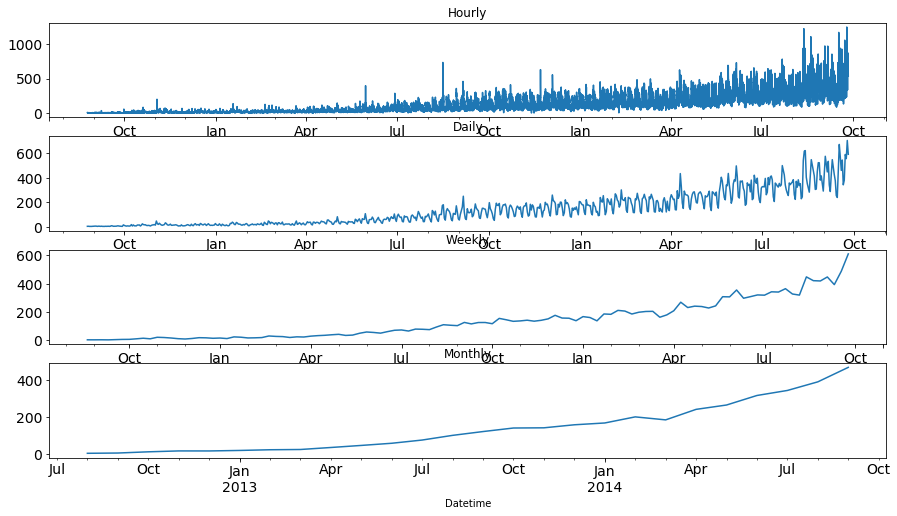

In [89]:
fig, axs = plt.subplots(4,1)

hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3])

plt.show()

We can see that the time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.

But it would be difficult to convert the monthly and weekly predictions to hourly predictions, as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, which will become very expanded process. So, we will work on the daily time series.

In [91]:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 

# Converting to daily mean
test = test.resample('D').mean()

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp

# Converting to daily mean
train = train.resample('D').mean()

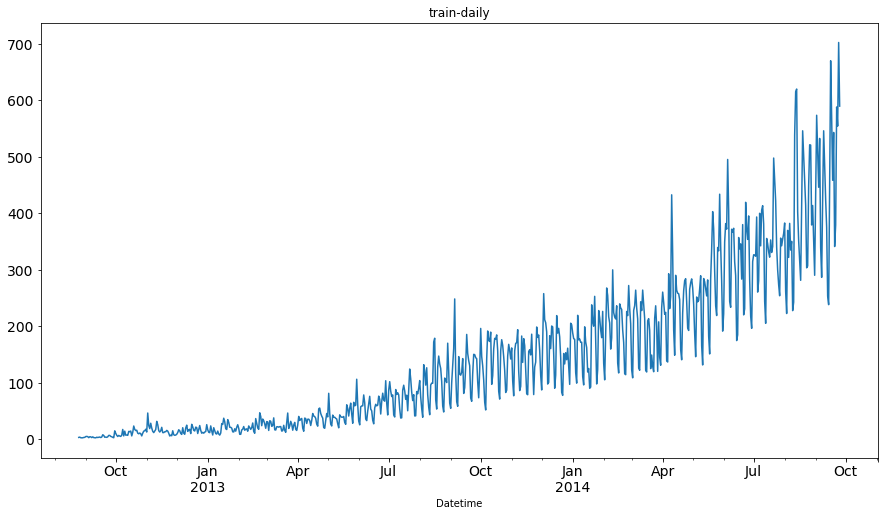

In [97]:
train.Count.plot(figsize=(15,8), title= 'train-daily', fontsize=14)

plt.show()